In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [20]:
file_path = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-smoothed-2025-07-07-16-47-35.tsv"
df = pd.read_csv(file_path, sep="\t", skiprows=5)

In [21]:
#清理欄位名稱
df.columns = [col.strip().lstrip('#').strip() for col in df.columns]
print("讀到的欄位名稱：", df.columns)

讀到的欄位名稱： Index(['smooth: Gaussian', 'Unnamed: 1'], dtype='object')


In [22]:
#確保兩欄都是數值
df[df.columns[0]] = pd.to_numeric(df[df.columns[0]], errors="coerce")
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors="coerce")
df = df.dropna()

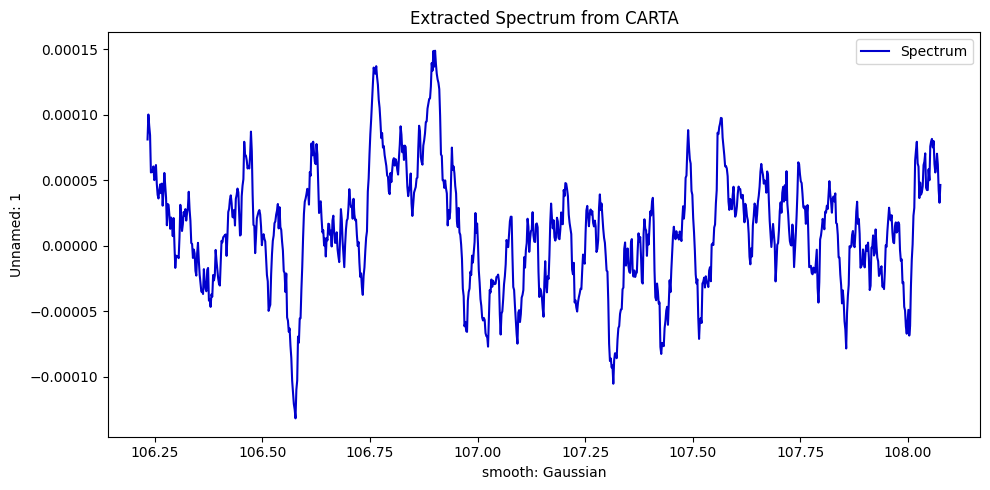

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Spectrum", color="mediumblue")
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Extracted Spectrum from CARTA")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
y_smoothed = gaussian_filter1d(df[df.columns[1]], sigma=12)

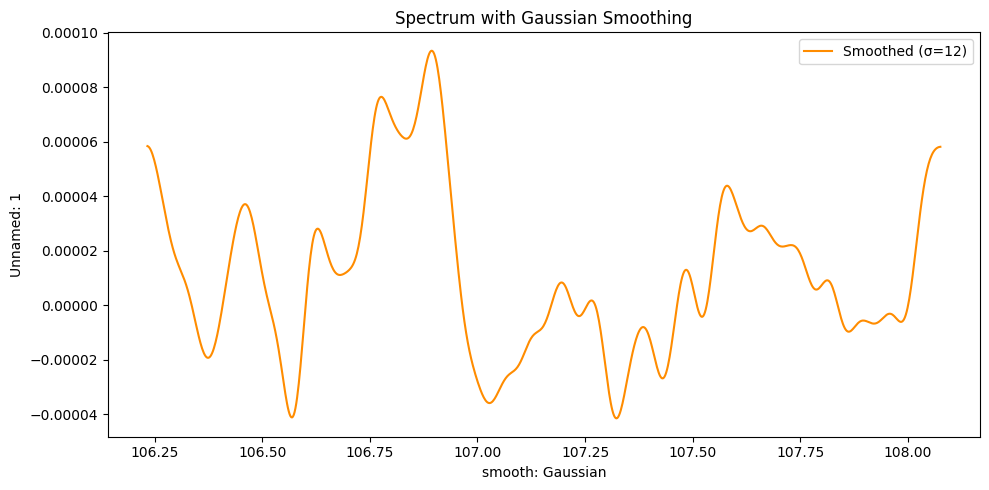

In [29]:
plt.figure(figsize=(10, 5))
#plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original Spectrum", color="mediumblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_smoothed, label="Smoothed (σ=12)", color="darkorange")
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Spectrum with Gaussian Smoothing")
plt.legend()
plt.tight_layout()
plt.show()